<CENTER>
<img src="https://sdk.tradingmotion.com/Img/TMSDK.png" width="200px">

  <header>
    <h1>Herramientas python para el análisis de sistemas automáticos</h1>
    <h3>Robotrader X - 9 Marzo 2020</h3>
    <h2>victor@ibroker.es</h2>
    <p></p>
  </header>
</CENTER>

In [49]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import pandas as pd
import numpy as np

import os
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = (16, 6)

import seaborn as sns

sns.set_context("notebook", font_scale=1.4)
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')


# Contenido

- Introducción a pandas / numpy
- Dataset estrategias Tradingmotion - Exploratory Data Analysis
- Métricas de rendimiento
- ¿El sistema ha dejado de funcionar?
- Construir un ránking de sistemas
- Crear una carteras de sistemas

Para ver este _notebook_ en formato de presentación:

```
jupyter nbconvert pyTradingmotion.ipynb --to slides --post serve
```

# Introducción a Pandas y numpy

* **numpy** - Librería fundamental para la computación científica en Python
* **pandas** - Herramienta para el análisis y manipulación de datos en Python

# Ejemplo numpy

Arrays multi-dimensional y funciones vectorizadas

In [18]:
print('Vector: ',np.arange(0.1, 1.0, 0.1))

Vector:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [19]:
print('Media aritmética vector: ', np.mean(np.arange(0.1, 1.0, 0.1)))

Media aritmética vector:  0.5


# Ejemplo pandas

Importación/exportación de datos. Dataframes.

In [22]:
df_population = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
df_population.head(2)

,Country Name,Country Code,Year,Value
0,Arab World,ARB,1960,92490932.0
1,Arab World,ARB,1961,95044497.0


In [51]:
df_population[df_population["Country Name"]=="Spain"].tail()

,Country Name,Country Code,Year,Value
12744,Spain,ESP,2012,46773055.0
12745,Spain,ESP,2013,46620045.0
12746,Spain,ESP,2014,46480882.0
12747,Spain,ESP,2015,46447697.0
12748,Spain,ESP,2016,46443959.0


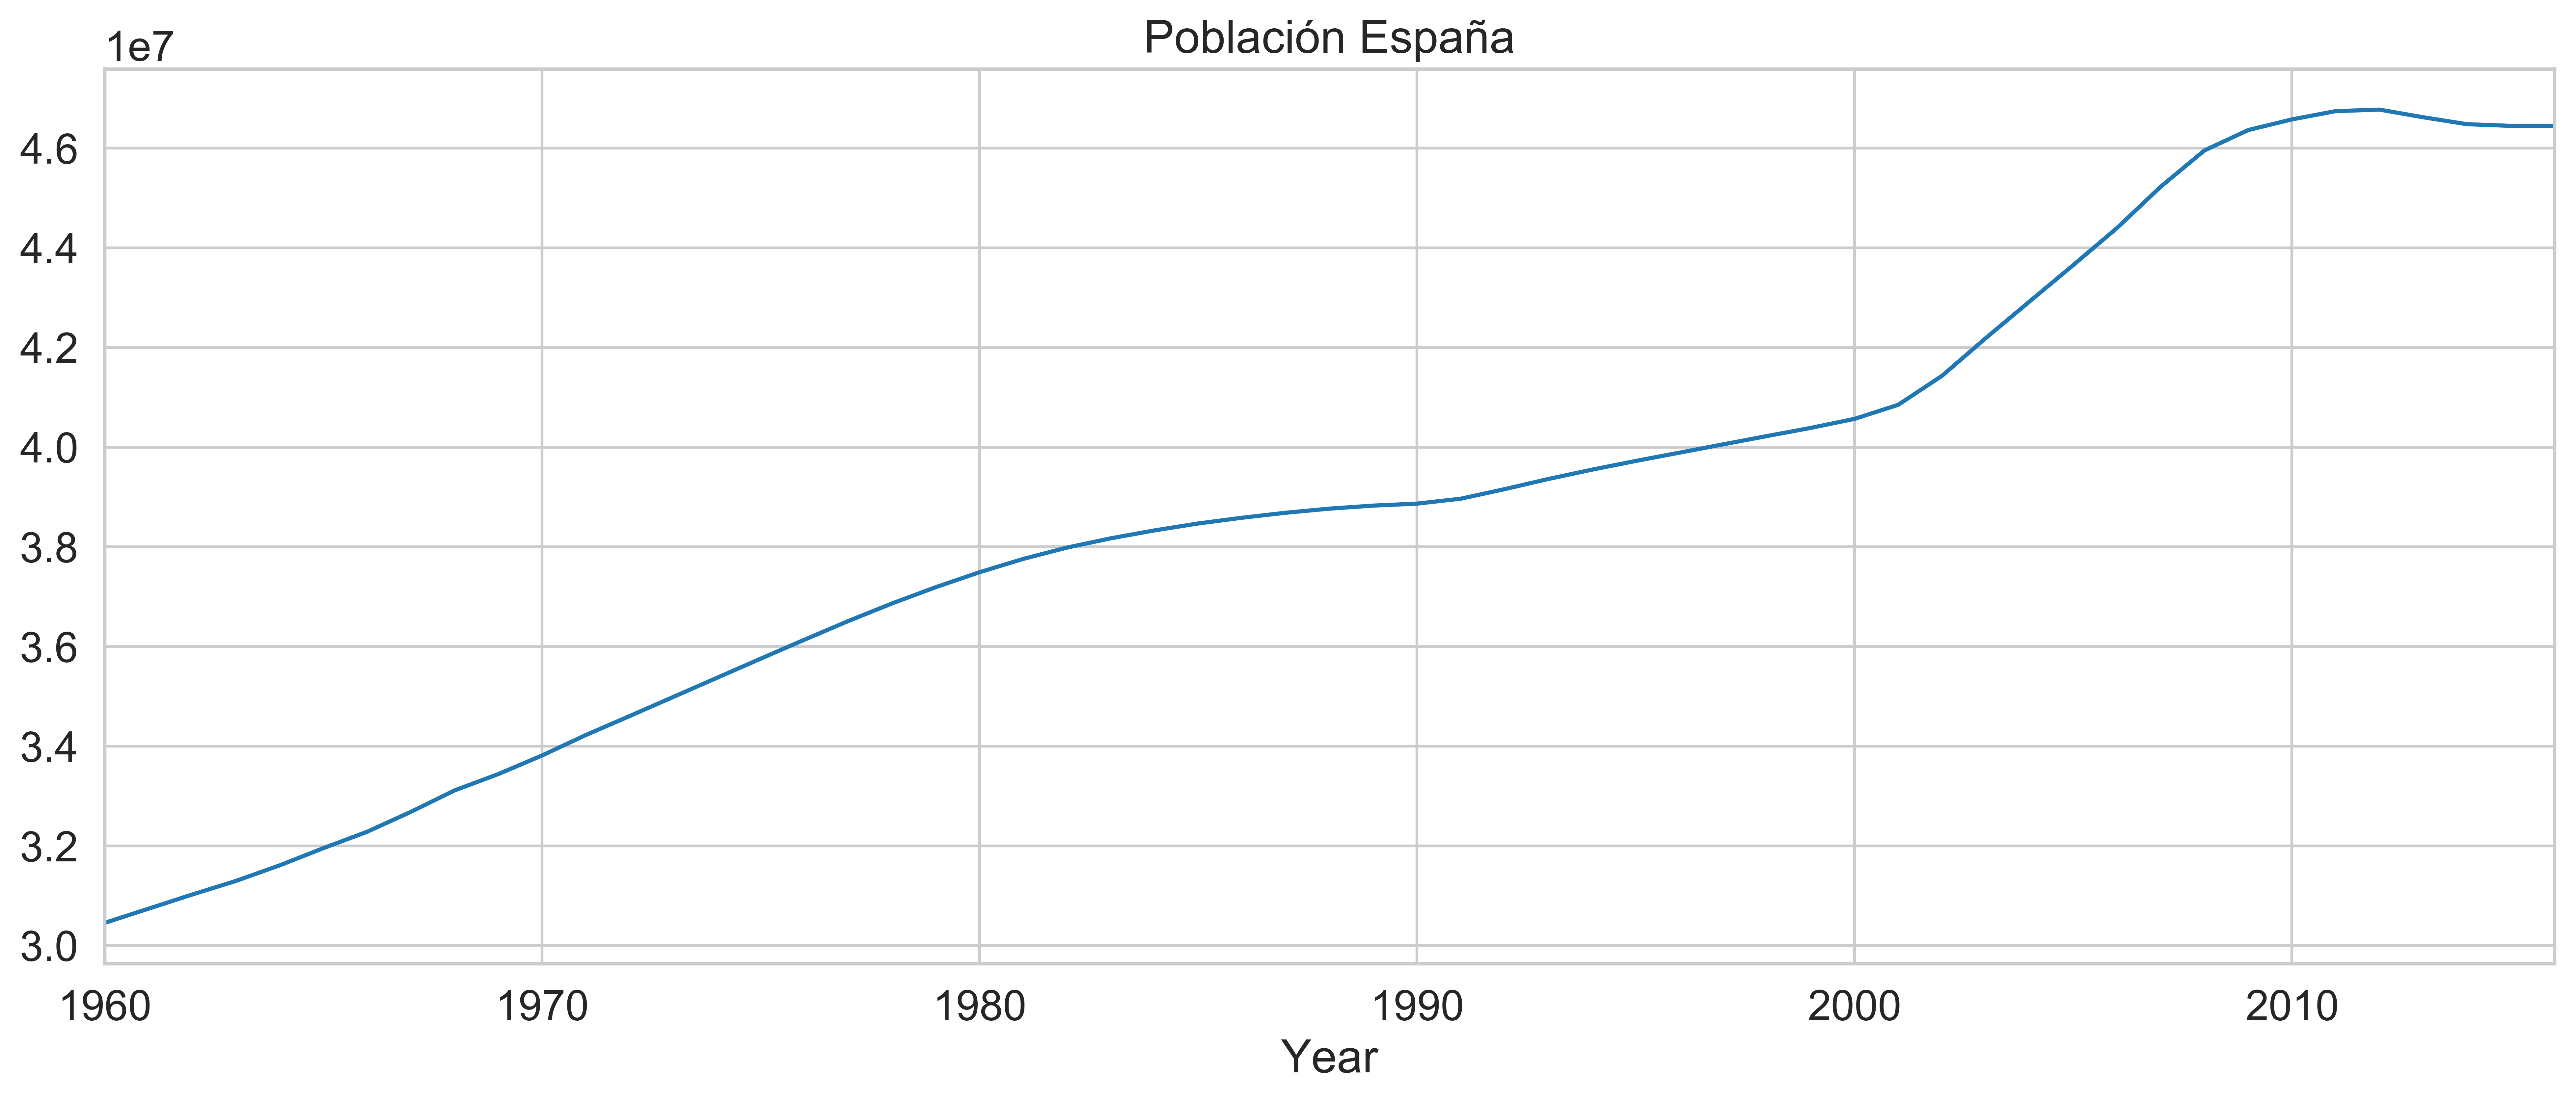

In [52]:
df_population[df_population["Country Name"]=="Spain"] \
    .set_index("Year")["Value"] \
    .plot(title="Población España");

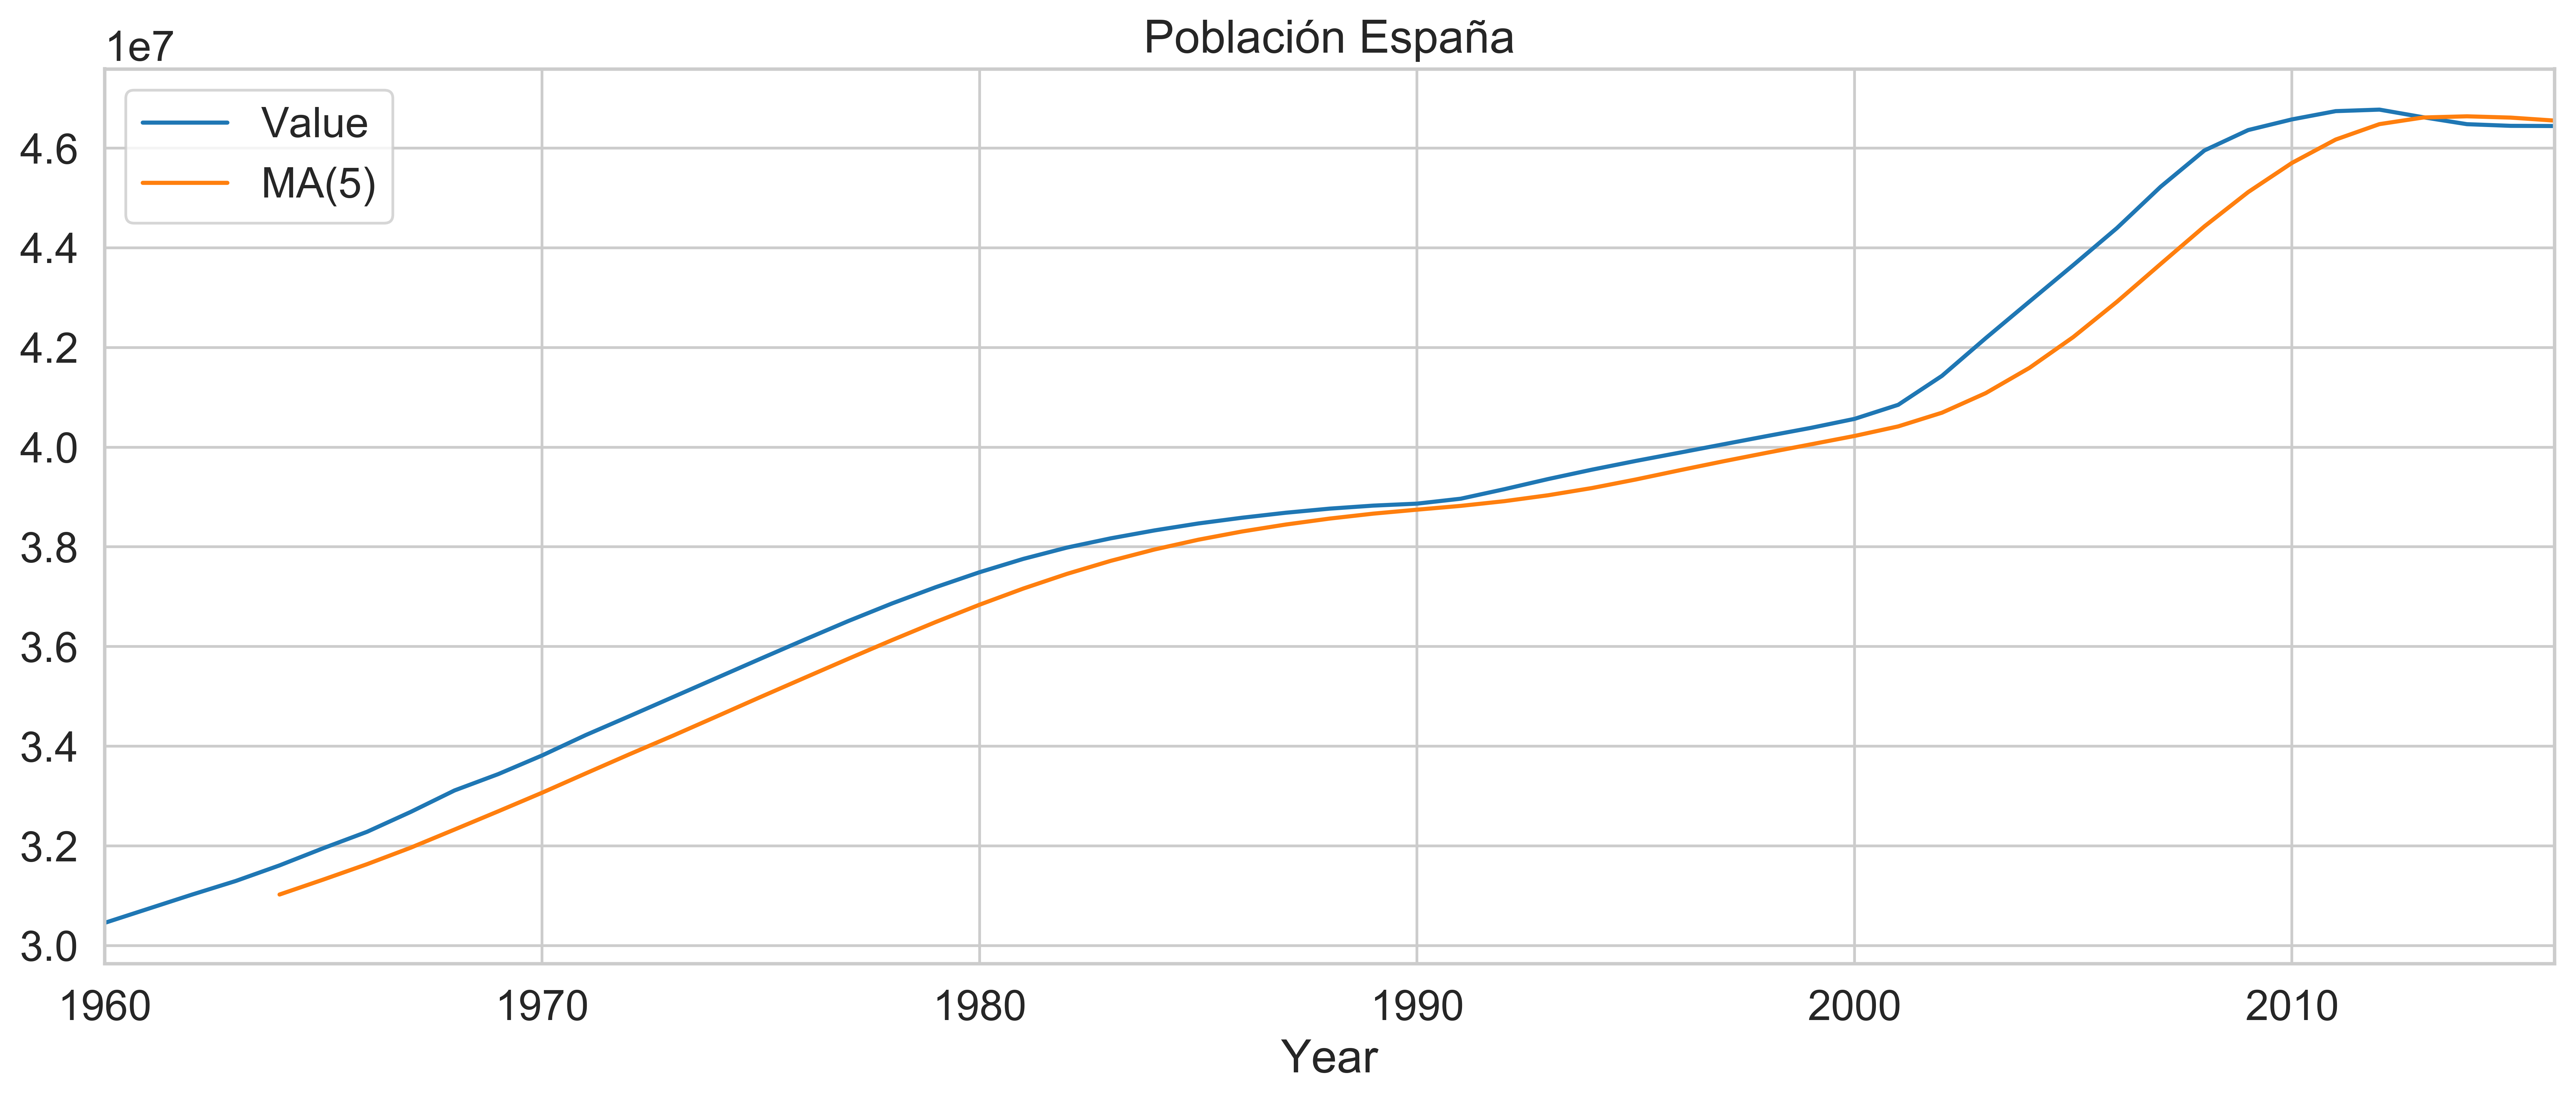

In [54]:
df_spain = df_population[df_population["Country Name"]=="Spain"].set_index("Year")
df_spain["MA(5)"] = df_spain["Value"].rolling(5).mean()

df_spain.plot(title="Población España");

# Exploratory Data Analysis (EDA)


Exploramos los datos disponibles de los sistemas en tradingmotion.com


# Contenido del dataset

* **strategies.csv.gz** - Atributos genearles de los 2k+ sistemas del marketplace tradingmotion.com
* **performances.csv.gz** - Timeseries de _rendimientos_ diarios de cada sistema

## strategies.csv.gz
Cargamos el dataset con la librerías [pandas](https://pandas.org)

In [41]:
# Cargamos el CSV en un pandas DataFrame
df_strategies = pd.read_csv('data/strategies.csv.gz', 
                            compression='gzip',
                            encoding='utf-8',
                            parse_dates=["CurrentPositionTime",
                                         "FirstBackTestedDate",
                                         "FirstTradeDate",
                                         "ReleaseDate",
                                         "StatsLastUpdated"]).set_index("IdStrategyVersion")

In [42]:
# Campos del dataset strategies
df_strategies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2179 entries, 12471 to 12469
Data columns (total 22 columns):
AcceptsNewClients          2179 non-null bool
CurrentPosition            2179 non-null int64
CurrentPositionTime        2179 non-null datetime64[ns, pytz.FixedOffset(120)]
FirstBackTestedDate        2179 non-null datetime64[ns]
FirstTradeDate             1124 non-null datetime64[ns]
HasClients                 2179 non-null bool
IdStrategy                 2179 non-null int64
Intraday                   2179 non-null bool
License_Currency           2179 non-null object
License_MonthlyCost        2179 non-null float64
License_nUnits             2179 non-null int64
MaxOpenPosition            2179 non-null int64
ProductID                  2179 non-null object
RecomReqCapitalCurrency    2179 non-null object
RecommendedCapital         2179 non-null float64
ReleaseDate                2179 non-null datetime64[ns]
RequiredCapital            2179 non-null float64
SlippagePerContract     

In [43]:
# Propiedades estrategia "Samurai Cooper" - https://tradingmotion.com/explore/System/PerformanceSheet?Id=21778
df_strategies.loc[21778].to_frame()

,21778
AcceptsNewClients,True
CurrentPosition,0
CurrentPositionTime,2019-09-12 20:00:00+02:00
FirstBackTestedDate,2017-01-03 00:00:00
FirstTradeDate,2019-03-29 00:00:00
HasClients,True
IdStrategy,17649
Intraday,False
License_Currency,EUR
License_MonthlyCost,60


In [56]:
import datetime

# Sistemas Ibex con clientes que requieran menos de 2000 €
df_strategies[
    (df_strategies["HasClients"] == True) &
    (df_strategies["ProductID"] == "ES") &
    (df_strategies["RequiredCapital"] < 2000)
]

,AcceptsNewClients,CurrentPosition,CurrentPositionTime,FirstBackTestedDate,FirstTradeDate,HasClients,IdStrategy,Intraday,License_Currency,License_MonthlyCost,...,ProductID,RecomReqCapitalCurrency,RecommendedCapital,ReleaseDate,RequiredCapital,SlippagePerContract,StatsLastUpdated,StrategyVersionName,TM_Rating,systemVersionIdentifier
IdStrategyVersion,,,,,,,,,,,,,,,,,,,,,
10891,True,0,2019-09-13 03:00:00+02:00,2005-01-13,2016-02-22,True,10380,True,EUR,40.0,...,ES,EUR,20000.0,2016-01-11,1900.0,-0.134317,2019-09-12 23:15:24.240000+02:00,Steel III mini S&P,3.0,0
17173,True,0,2019-09-13 03:00:00+02:00,2002-09-04,2016-03-24,True,17104,True,EUR,40.0,...,ES,EUR,25000.0,2015-05-04,1800.0,-0.120214,2019-09-12 23:23:00.540000+02:00,Bloodhound Mini S&P,3.0,0
12477,True,0,2019-09-12 22:00:00+02:00,2008-01-02,2018-12-20,True,12291,True,EUR,115.0,...,ES,EUR,20000.0,2018-07-24,1500.0,-0.166535,2019-09-12 23:16:34+02:00,Spring ES,3.0,0
17204,True,0,2019-09-12 21:55:00+02:00,2002-01-02,2014-10-09,True,17120,True,EUR,100.0,...,ES,EUR,25000.0,2014-10-03,1500.0,-0.100827,2019-09-12 23:22:58.773000+02:00,Mini SP500 Clock,1.0,0
12138,True,0,2019-09-12 22:15:00+02:00,2006-01-10,2016-06-16,True,12113,True,EUR,170.0,...,ES,EUR,20000.0,2016-05-31,1500.0,-0.137487,2019-09-12 23:27:27.587000+02:00,BattleQuant ES,1.0,0
21766,True,0,2019-09-13 03:00:00+02:00,2016-11-01,2019-01-09,True,17594,True,EUR,105.0,...,ES,EUR,25000.0,2018-12-11,1500.0,-0.142518,2019-09-12 23:15:19.407000+02:00,ZigZag6 _ E-mini S&P ES,3.0,0
21689,True,-1,2019-09-13 03:00:00+02:00,2016-01-04,2018-10-29,True,17594,True,EUR,115.0,...,ES,EUR,35000.0,2018-10-22,1900.0,-0.121814,2019-09-13 00:05:58.557000+02:00,ZigZag 6B _ E-mini S&P ES,3.0,0
21741,True,0,2019-09-13 03:05:00+02:00,2008-02-05,2018-12-12,True,17630,True,EUR,105.0,...,ES,EUR,10000.0,2018-11-22,1500.0,-0.142764,2019-09-12 23:36:43.650000+02:00,DT Rider M1C ES v2,3.0,0
21828,True,0,2019-09-12 21:00:00+02:00,2017-01-04,2019-05-07,True,17661,True,EUR,60.0,...,ES,EUR,15000.0,2019-02-02,1500.0,-0.133276,2019-09-12 23:21:48.193000+02:00,ICARO SP,3.0,0


## performances.csv.gz
Cargamos el dataset con la librerías [pandas](https://pandas.org)

In [45]:
# Cargamos el CSV en un pandas DataFrame
df_performances = pd.read_csv(
        'data/performances.csv.gz',
        compression='gzip',
        encoding='utf-8',
        parse_dates=['TradeDate']
    ).set_index(["IdStrategyVersion", "TradeDate"]).sort_index()

In [46]:
# Campos del dataset performances
df_performances.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5505882 entries, (10007, 2001-01-02 00:00:00) to (22299, 2020-02-05 00:00:00)
Data columns (total 21 columns):
AvgRealPerformance_Curr           float64
ConsolidatedPerformance_Curr      float64
ContractSettlePrice               float64
CurrencyConversionFactor          float64
EODPosition                       int64
LicenseCostCharge                 float64
PointValue                        float64
ProductCurrency                   object
RealPerformance_Avg               float64
RealPerformance_Best              float64
RealPerformance_Worst             float64
RequestedCurrency                 object
Slippage_Real                     float64
Slippage_Theo                     float64
TheoPerformance                   float64
TheoPerformance_Curr              float64
TradingType                       object
VolumeTraded                      int64
InstitutionalLicenseCostCharge    float64
PerformanceWithNoLicenseCharge    float64
Perfor

In [47]:
# Performance estrategia "Samurai Cooper" - últimas 5 sesiones
df_performances.loc[21778].tail(5)

,AvgRealPerformance_Curr,ConsolidatedPerformance_Curr,ContractSettlePrice,CurrencyConversionFactor,EODPosition,LicenseCostCharge,PointValue,ProductCurrency,RealPerformance_Avg,RealPerformance_Best,...,RequestedCurrency,Slippage_Real,Slippage_Theo,TheoPerformance,TheoPerformance_Curr,TradingType,VolumeTraded,InstitutionalLicenseCostCharge,PerformanceWithNoLicenseCharge,PerformanceInstitutional
TradeDate,,,,,,,,,,,,,,,,,,,,,
2020-01-30,283.3439,283.3439,2.549,0.906701,-1,0.0,25000.0,USD,0.0125,0.0125,...,EUR,0.000000,0.0,0.0125,283.3439,R,0,1.363636,283.3439,281.980264
2020-01-31,836.9526,836.9526,2.512,0.904814,-1,0.0,25000.0,USD,0.0370,0.0370,...,EUR,0.000000,0.0,0.0370,836.9526,R,0,1.363636,836.9526,835.588964
2020-02-03,-309.5970,-379.5373,2.507,0.903669,0,-60.0,25000.0,USD,-0.0137,-0.0135,...,EUR,-0.000204,0.0,-0.0135,-304.9883,R,1,1.500000,-319.5373,-321.037300
2020-02-04,196.3930,126.4365,2.545,0.905141,-1,-60.0,25000.0,USD,0.0087,0.0100,...,EUR,-0.001321,0.0,0.0100,226.2853,R,1,1.500000,186.4365,184.936500
2020-02-05,-907.1940,-907.1940,2.585,0.907194,-1,0.0,25000.0,USD,-0.0400,-0.0400,...,EUR,0.000000,0.0,-0.0400,-907.1940,R,0,1.500000,-907.1940,-908.694000


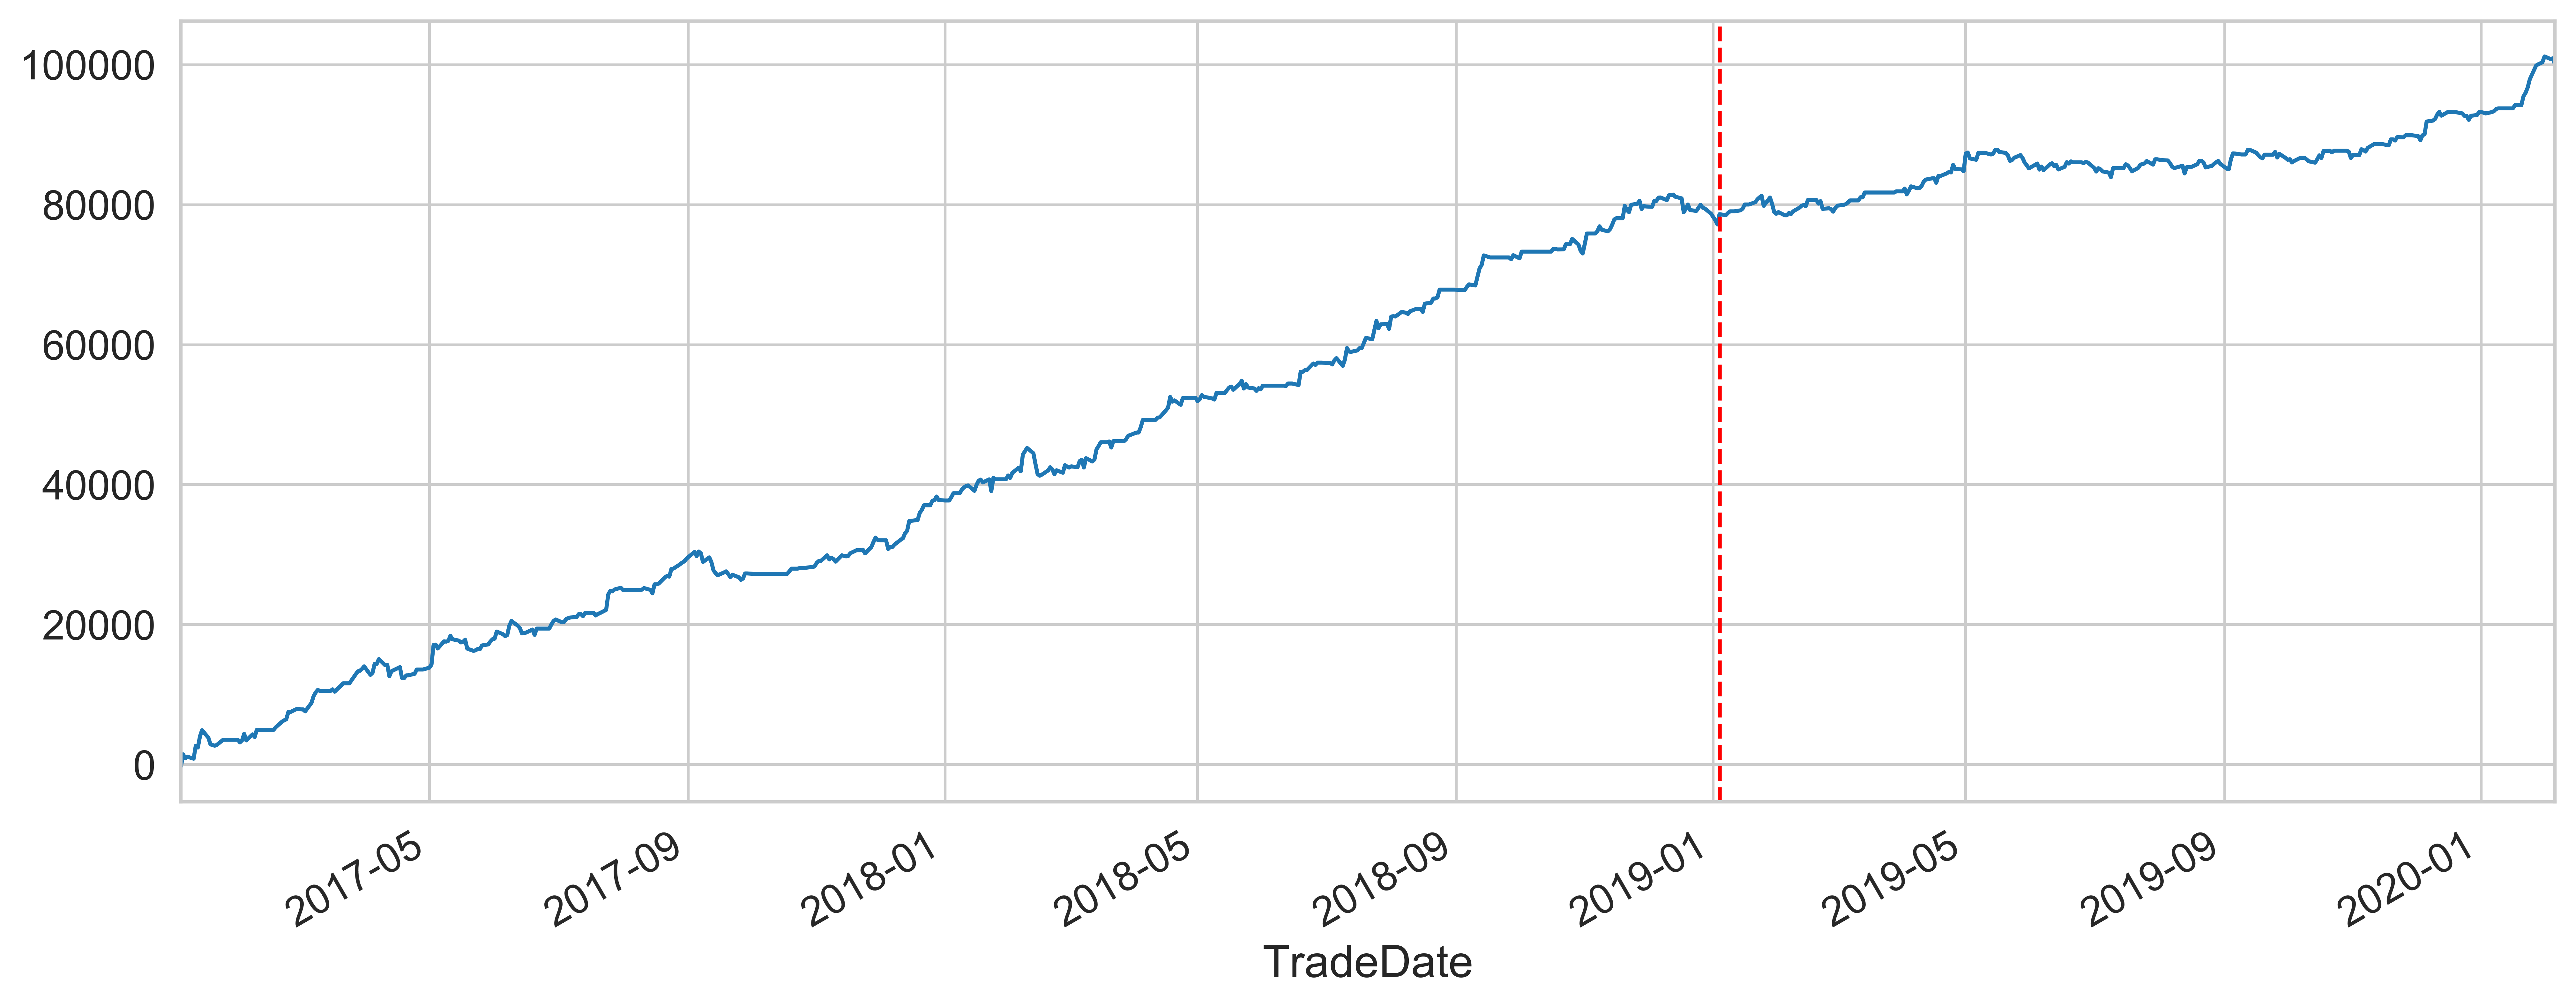

In [60]:
# Performance estrategia "Samurai Cooper" - gráfico
plot = df_performances.loc[21778]["ConsolidatedPerformance_Curr"].cumsum().plot();
# Marcamos la fecha de "verificación"
plot.axvline(df_strategies.loc[21778]["ReleaseDate"], color="red", linestyle="--");

# Distribución de retornos diarios - backtest

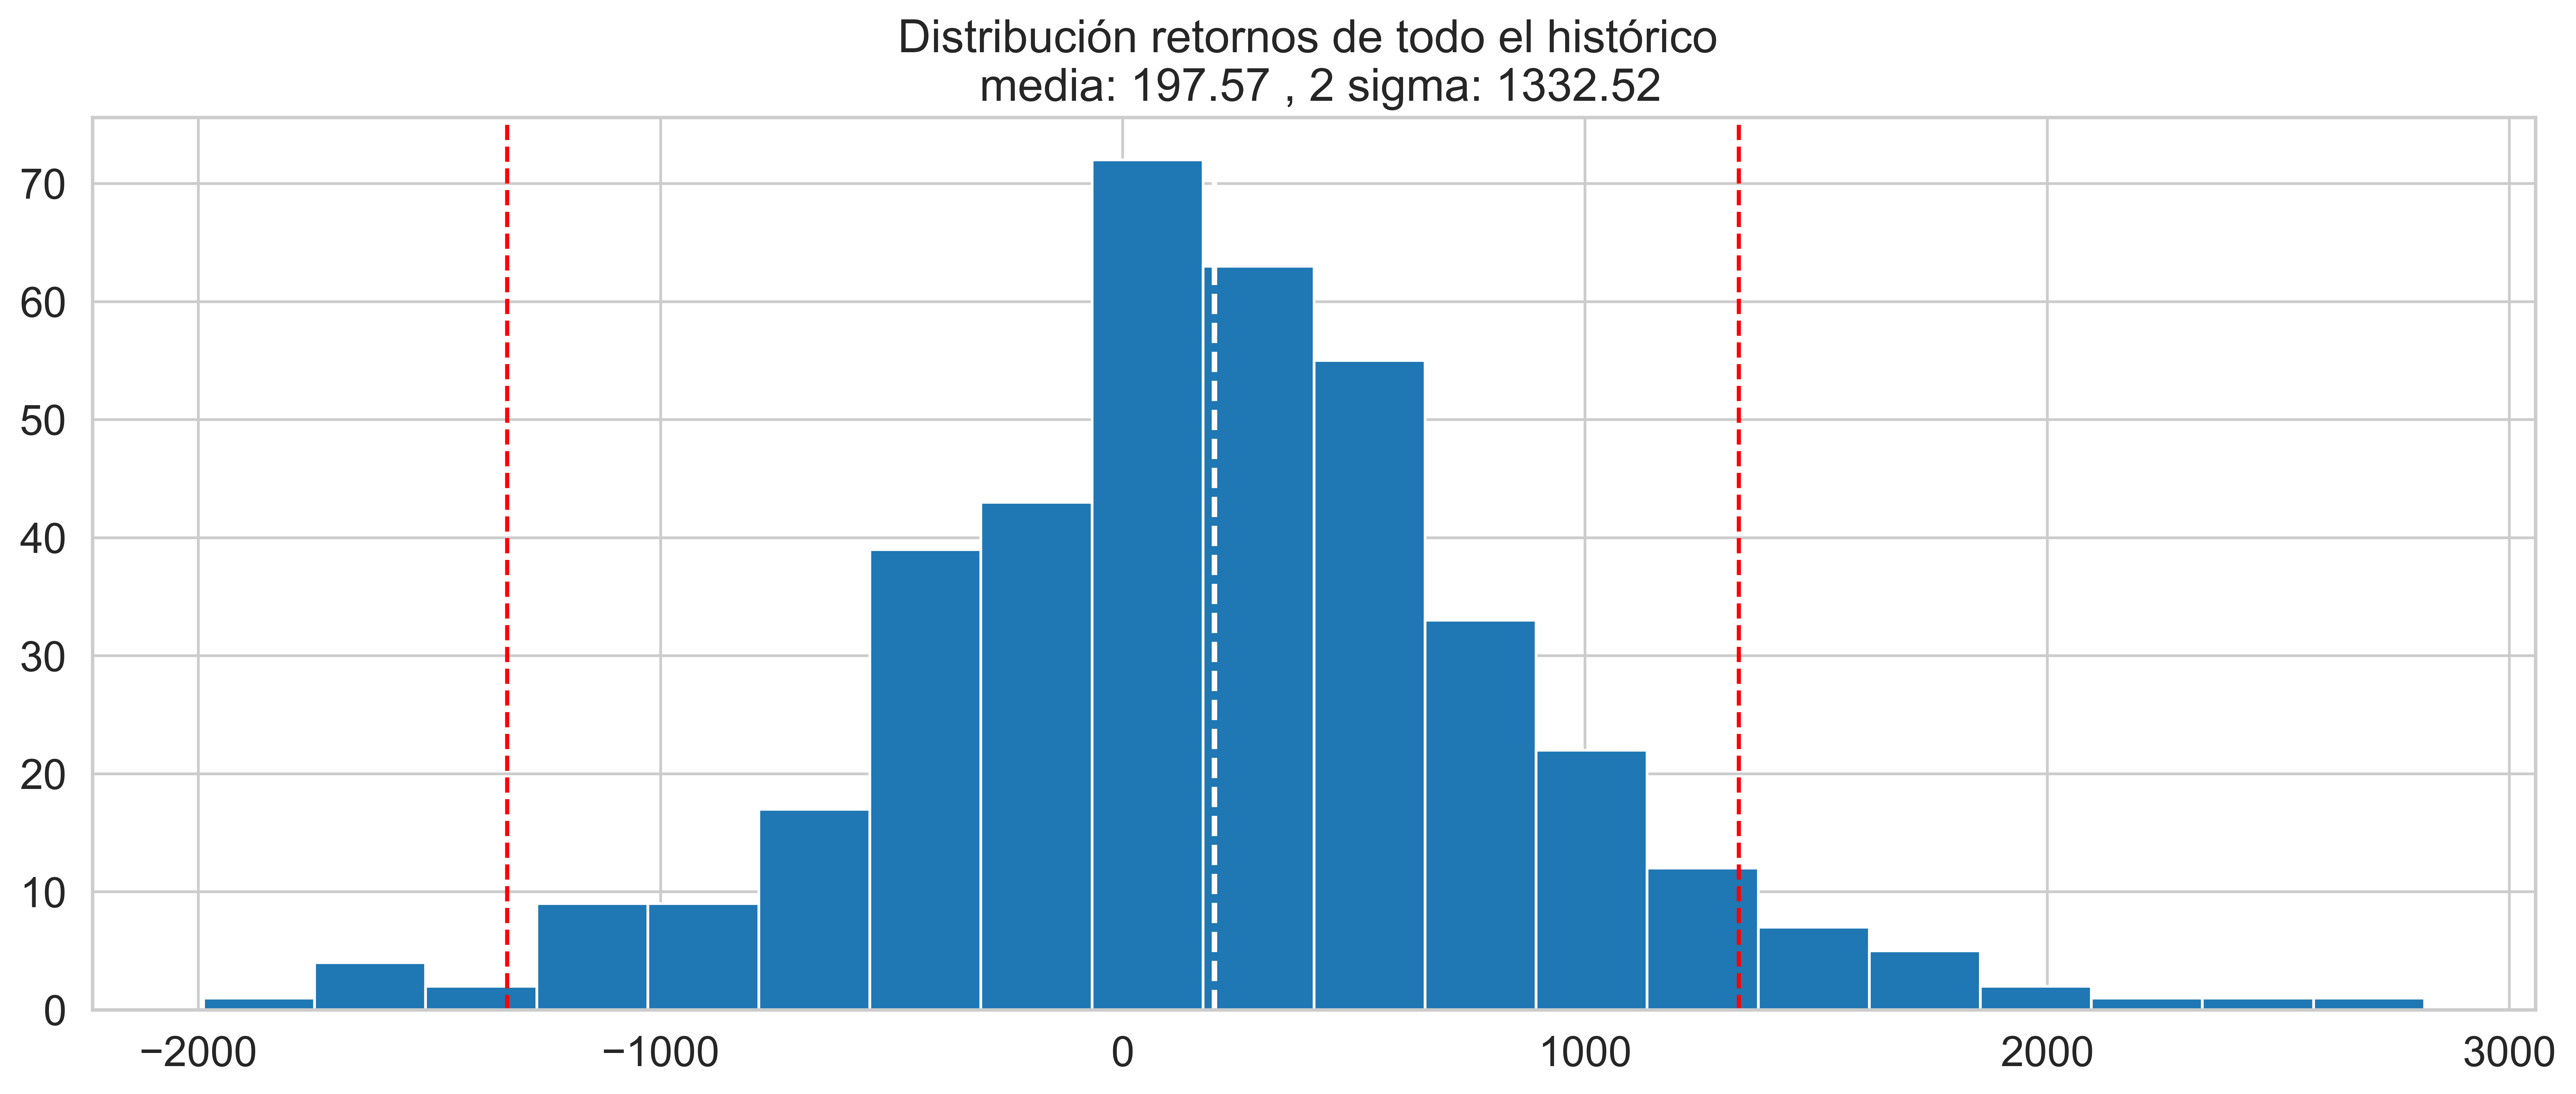

In [103]:
# Retornos diarios de todo el período (solamente sesiones con P&L!=0)
df_rtn = df_performances.loc[21778]["ConsolidatedPerformance_Curr"].replace(0, np.nan).dropna()
# Período backtest
df_rtn_insample = df_rtn[:df_strategies.loc[21778]["ReleaseDate"]]

df_rtn_insample.hist(bins=20)
plt.axvline(df_rtn_insample.mean().item(), color='w', linestyle='--', linewidth=2)
plt.axvline(2*df_rtn_insample.std().item(), color='r', linestyle='--')
plt.axvline(-2*df_rtn_insample.std().item(), color='r', linestyle='--')
plt.title("Distribución retornos de todo el histórico \n media: {:.2f} , 2 sigma: {:.2f}".format(
          df_rtn_insample.mean().item(), \
          2*df_rtn_insample.std().item()))
plt.show()

# Distribución de retornos diarios - live

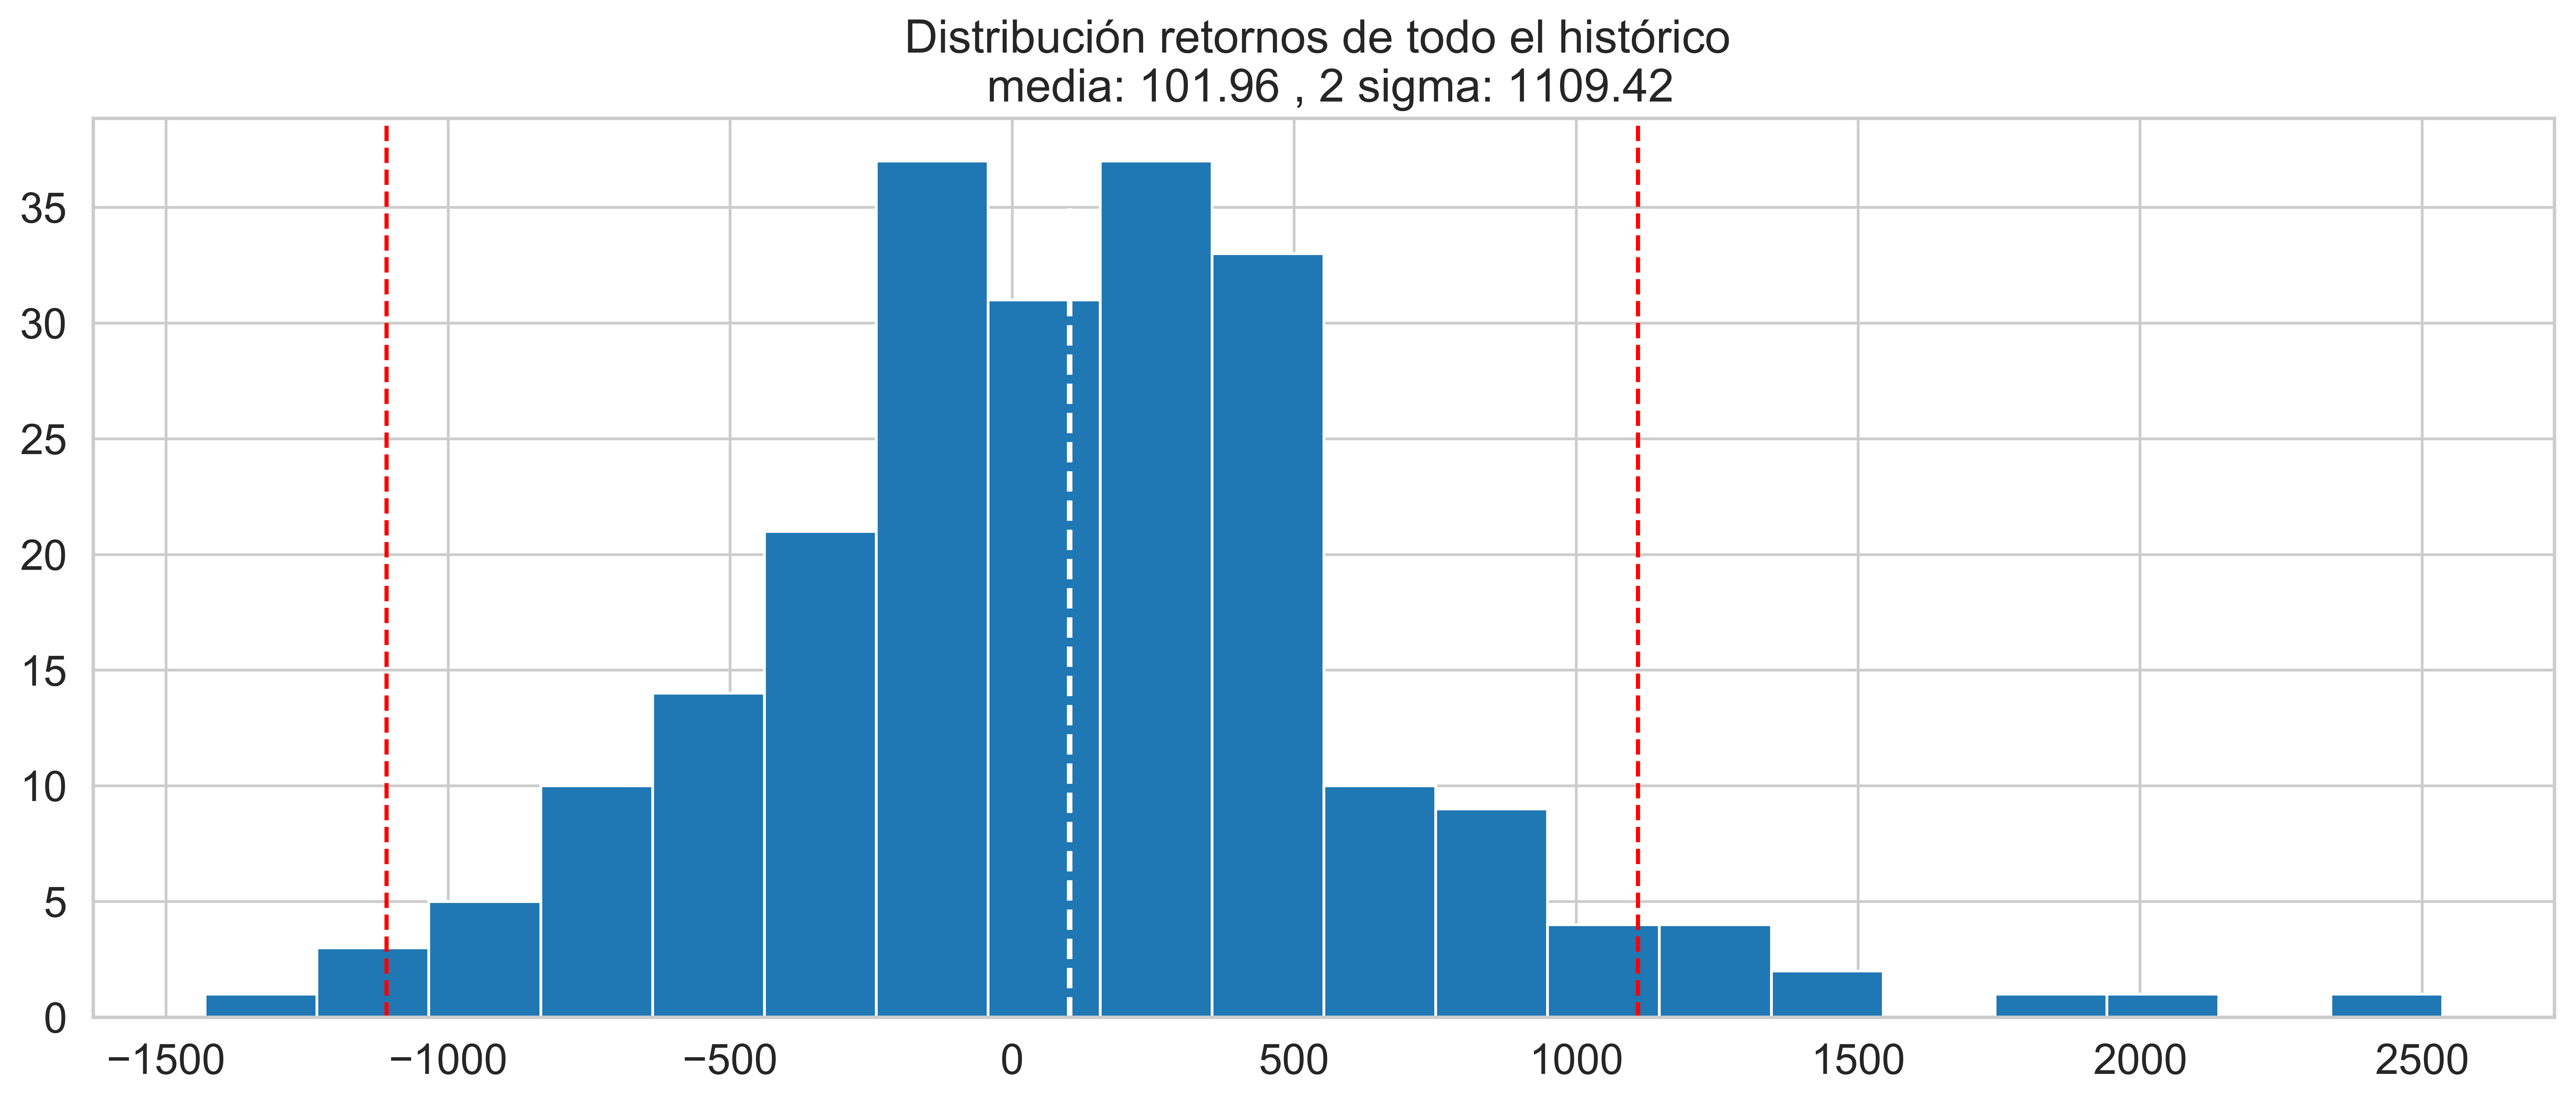

In [104]:
# Período validado
df_rtn_outsample = df_rtn[df_strategies.loc[21778]["ReleaseDate"]:]


df_rtn_outsample.hist(bins=20)
plt.axvline(df_rtn_outsample.mean().item(), color='w', linestyle='--', linewidth=2)
plt.axvline(2*df_rtn_outsample.std().item(), color='r', linestyle='--')
plt.axvline(-2*df_rtn_outsample.std().item(), color='r', linestyle='--')
plt.title("Distribución retornos de todo el histórico \n media: {:.2f} , 2 sigma: {:.2f}".format(
          df_rtn_outsample.mean().item(), \
          2*df_rtn_outsample.std().item()))
plt.show()